In [1]:
import h5py
import numpy as np
from tqdm.notebook import tqdm
import os
import glob
import matplotlib.pyplot as plt
import time

from train_transformer import *

from utils import *
from models import *

import warnings
warnings.filterwarnings('ignore')

assert torch.cuda.is_available()
device = 'cuda'

In [2]:
train_f = sorted(glob.glob('train_/*.hdf'))
# train_f.remove('../../stock_price/train\\20190425_20190510.hdf')
test_f = sorted(glob.glob('test_/*.hdf'))
# test_f.remove('../stock_price/test\IC2003_20191018.hdf') # batch为256时，第71个batch大小为2， 不足以用于预测

In [3]:
train_f = [train_f[0], train_f[4], train_f[6],train_f[-1]]
# train_f = train_f[-6:]
train_f

['train_\\20190401_20190412.hdf',
 'train_\\20190523_20190604.hdf',
 'train_\\20190617_20190628.hdf',
 'train_\\20190723_20190731.hdf']

In [4]:
# Hyperparams
enc_in = 15
dec_in = 2
c_out = 1 
seq_len = 20
out_len = 1
d_model = 32
d_ff = 16
n_heads = 4
label_len = 10
e_layers = 2
d_layers = 2
scaler = False
opt_s = False

decay = 100
dropout = 0.1
batch_size = 256
val_batch = 512
lr = 0.001

In [5]:
transformer = Train_transformer(enc_in, dec_in, c_out, seq_len, out_len, d_model, d_ff, n_heads, 
                                e_layers, d_layers, label_len,
                                dropout, batch_size, val_batch, lr,
                              device, train_f, test_f,scaler, decay, opt_s)

In [6]:
transformer._build_model(opt=None, m='lstm')

Transformer_LSTM(
  (encoder): LSTM(15, 32, num_layers=2, batch_first=True, dropout=0.1)
  (decoder): LSTM(2, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attn): AttentionLayer(
    (inner_attention): Attention()
    (query_projection): Linear(in_features=32, out_features=64, bias=True)
    (key_projection): Linear(in_features=32, out_features=64, bias=True)
    (value_projection): Linear(in_features=32, out_features=64, bias=True)
    (out_projection): Linear(in_features=64, out_features=32, bias=True)
  )
  (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (d_fc1): Linear(in_features=320, out_features=64, bias=True)
  (d_fc2): Linear(in_features=64, out_features=32, bias=True)
  (out_fc1): Linear(in_features=160, out_features=64, bias=True)
  (out_fc2): Linear(in_features=64, out_features=64, bias=True)
  (out_fc3): Linear(in_features=64, out_features=32, bias=True)
  (out_fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [7]:
transformer._selct_criterion('huber', beta=0.2)

In [8]:
print("Total number of paramerters in networks is {}  ".format(sum(x.numel() for x in transformer.model.parameters())))

Total number of paramerters in networks is 75457  


In [9]:
transformer._selct_optim('adam')
transformer._selct_scheduler(opt='plateau',patience=10, factor=0.1, step=1000)
# Informer._selct_scheduler(opt='cyclic',base_lr=0.001, max_lr=0.005)

In [10]:
transformer.preview_noam()

AttributeError: Only support Noam Schedule now

In [10]:
transformer.val_every=True
transformer.test_every = False

In [11]:
transformer._set_lr(0.001)

Learning Rate is set to 0.001


  0%|          | 0/5 [00:00<?, ?it/s]

After training train_\20190401_20190412  Train_loss:0.762313 R2:0.249934 | Val_Loss:0.713123 |R2:0.334463 |Rate:0.702 |lr:0.001000
After training train_\20190523_20190604  Train_loss:0.660139 R2:0.318585 | Val_Loss:0.667283 |R2:0.332281 |Rate:0.689 |lr:0.001000
After training train_\20190617_20190628  Train_loss:0.514726 R2:0.340750 | Val_Loss:0.509900 |R2:0.372088 |Rate:0.695 |lr:0.001000
After training train_\20190723_20190731  Train_loss:0.445488 R2:0.345424 | Val_Loss:0.452227 |R2:0.352304 |Rate:0.672 |lr:0.001000
Save here
Epoch:  1 |Train_Loss:0.595667 |R2:0.313673|Val_Loss:0.585633 |R2:0.347784 |Rate:0.690 |lr:0.001000
Test_Loss:0.410364 |R2:0.329671 |Rate:0.678 
Validation R2 increased (-inf --> 0.347784).  Saving model ...
After training train_\20190401_20190412  Train_loss:0.696229 R2:0.367983 | Val_Loss:0.692166 |R2:0.383678 |Rate:0.709 |lr:0.001000
After training train_\20190523_20190604  Train_loss:0.625976 R2:0.380534 | Val_Loss:0.617555 |R2:0.411621 |Rate:0.721 |lr:0.001

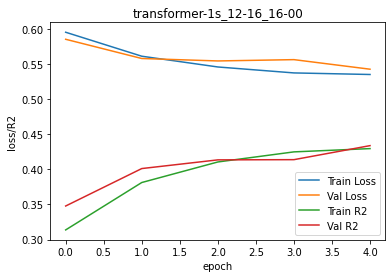

In [12]:
transformer.train(epochs=5, train_all=True, f='../../stock_price/train\\20190723_20190731.hdf',
            val_size=0.2, test_round=1, save='train',patience=40)

In [13]:
transformer._selct_optim('sgd')
transformer._selct_scheduler(opt='plateau',patience=10, factor=0.1, step=4000)

  0%|          | 0/5 [00:00<?, ?it/s]

After training train_\20190401_20190412  Train_loss:0.760398 R2:0.256438 | Val_Loss:0.741799 |R2:0.282194 |Rate:0.683 |lr:0.001000
After training train_\20190523_20190604  Train_loss:0.679770 R2:0.275679 | Val_Loss:0.668165 |R2:0.316949 |Rate:0.687 |lr:0.001000
After training train_\20190617_20190628  Train_loss:0.516628 R2:0.332374 | Val_Loss:0.519388 |R2:0.341612 |Rate:0.686 |lr:0.001000
After training train_\20190723_20190731  Train_loss:0.439804 R2:0.352361 | Val_Loss:0.450951 |R2:0.350979 |Rate:0.673 |lr:0.001000
Save here
Epoch:  5 |Train_Loss:0.599150 |R2:0.304213|Val_Loss:0.595076 |R2:0.322934 |Rate:0.682 |lr:0.001000
Test_Loss:0.410457 |R2:0.329258 |Rate:0.682 
Validation R2 increased (-inf --> 0.322934).  Saving model ...
After training train_\20190401_20190412  Train_loss:0.726098 R2:0.314195 | Val_Loss:0.720907 |R2:0.321151 |Rate:0.696 |lr:0.001000
After training train_\20190523_20190604  Train_loss:0.648695 R2:0.332160 | Val_Loss:0.658202 |R2:0.337838 |Rate:0.694 |lr:0.001

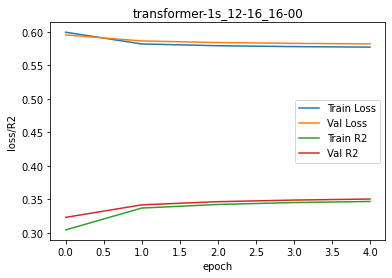

In [14]:
transformer.train(epochs=5, train_all=True, f='../../stock_price/train\\20190723_20190731.hdf',
            val_size=0.2, test_round=1, save='train',patience=40)

  0%|          | 0/10 [00:00<?, ?it/s]

After training train_\20190401_20190412  Train_loss:0.715101 R2:0.332374 | Val_Loss:0.711079 |R2:0.337653 |Rate:0.700 |lr:0.001000
After training train_\20190523_20190604  Train_loss:0.643642 R2:0.343409 | Val_Loss:0.653432 |R2:0.347671 |Rate:0.697 |lr:0.001000
After training train_\20190617_20190628  Train_loss:0.507173 R2:0.355888 | Val_Loss:0.510586 |R2:0.363351 |Rate:0.696 |lr:0.001000
After training train_\20190723_20190731  Train_loss:0.439156 R2:0.360220 | Val_Loss:0.449728 |R2:0.357231 |Rate:0.676 |lr:0.001000
Save here
Epoch:  9 |Train_Loss:0.576268 |R2:0.347973|Val_Loss:0.581206 |R2:0.351476 |Rate:0.692 |lr:0.001000
Test_Loss:0.405365 |R2:0.342279 |Rate:0.687 
Validation R2 increased (-inf --> 0.351476).  Saving model ...
After training train_\20190401_20190412  Train_loss:0.714260 R2:0.333542 | Val_Loss:0.710201 |R2:0.339194 |Rate:0.701 |lr:0.001000
After training train_\20190523_20190604  Train_loss:0.643336 R2:0.344415 | Val_Loss:0.653014 |R2:0.348592 |Rate:0.697 |lr:0.001

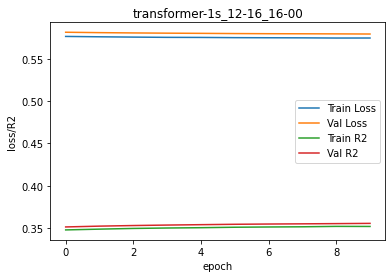

In [15]:
transformer.train(epochs=10, train_all=True, f='../../stock_price/train\\20190723_20190731.hdf',
            val_size=0.2, test_round=1, save='train',patience=40)

Learning Rate is set to 0.0005


  0%|          | 0/2 [00:00<?, ?it/s]

After training train_\20190401_20190412  Train_loss:0.682629 R2:0.391860 | Val_Loss:0.790918 |R2:0.267905 |Rate:0.656 |lr:0.000500
After training train_\20190523_20190604  Train_loss:0.601425 R2:0.429963 | Val_Loss:0.578054 |R2:0.484310 |Rate:0.736 |lr:0.000500
After training train_\20190617_20190628  Train_loss:0.482309 R2:0.416567 | Val_Loss:0.465209 |R2:0.457086 |Rate:0.727 |lr:0.000500
After training train_\20190723_20190731  Train_loss:0.419781 R2:0.415821 | Val_Loss:0.428744 |R2:0.427162 |Rate:0.690 |lr:0.000500
Save here
Epoch: 18 |Train_Loss:0.546536 |R2:0.413553|Val_Loss:0.565731 |R2:0.409116 |Rate:0.703 |lr:0.000500
Test_Loss:0.476840 |R2:0.156816 |Rate:0.628 
Validation R2 increased (-inf --> 0.409116).  Saving model ...
After training train_\20190401_20190412  Train_loss:0.637849 R2:0.464218 | Val_Loss:0.642056 |R2:0.466982 |Rate:0.738 |lr:0.000500
After training train_\20190523_20190604  Train_loss:0.581006 R2:0.462796 | Val_Loss:0.574892 |R2:0.492105 |Rate:0.738 |lr:0.000

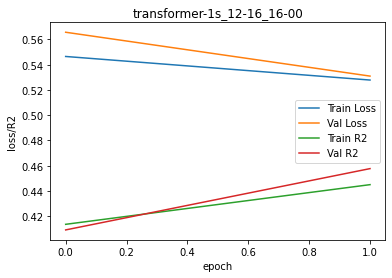

In [16]:
transformer._selct_optim('adamW')
transformer._selct_scheduler(opt='plateau',patience=10, factor=0.1, step=4000)
transformer._set_lr(0.0005)
transformer.train(epochs=2, train_all=True, f='../../stock_price/train\\20190723_20190731.hdf',
            val_size=0.2, test_round=1, save='train',patience=40)

Learning Rate is set to 0.0005


  0%|          | 0/10 [00:00<?, ?it/s]

After training train_\20190401_20190412  Train_loss:0.836770 R2:0.107672 | Val_Loss:0.773245 |R2:0.221451 |Rate:0.665 |lr:0.000500
After training train_\20190523_20190604  Train_loss:0.688107 R2:0.250729 | Val_Loss:0.676569 |R2:0.297481 |Rate:0.687 |lr:0.000500
After training train_\20190617_20190628  Train_loss:0.527447 R2:0.308396 | Val_Loss:0.524162 |R2:0.325864 |Rate:0.684 |lr:0.000500
After training train_\20190723_20190731  Train_loss:0.448385 R2:0.327837 | Val_Loss:0.452712 |R2:0.339513 |Rate:0.672 |lr:0.000500
Save here
Epoch: 19 |Train_Loss:0.625177 |R2:0.248659|Val_Loss:0.606672 |R2:0.296077 |Rate:0.677 |lr:0.000500
Test_Loss:0.410943 |R2:0.322487 |Rate:0.681 
Validation R2 increased (-inf --> 0.296077).  Saving model ...
After training train_\20190401_20190412  Train_loss:0.750009 R2:0.271557 | Val_Loss:0.736784 |R2:0.289615 |Rate:0.689 |lr:0.000500
After training train_\20190523_20190604  Train_loss:0.663028 R2:0.303874 | Val_Loss:0.666921 |R2:0.316631 |Rate:0.690 |lr:0.000

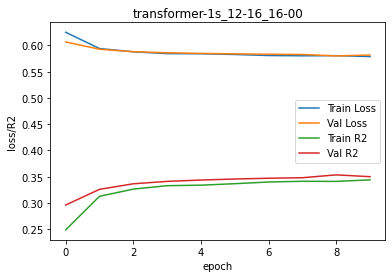

In [17]:
transformer._selct_optim('sgd')
transformer._selct_scheduler(opt='plateau',patience=10, factor=0.1, step=4000)
transformer._set_lr(0.0005)
transformer.train(epochs=10, train_all=True, f='../../stock_price/train\\20190723_20190731.hdf',
            val_size=0.2, test_round=1, save='train',patience=40)